In [45]:
import tensorflow as tf

def integrated_gradients(input_image, model, steps=50):
    # Generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=steps+1)

    # Initialize TensorArray outside loop to collect gradients
    gradient_batches = tf.TensorArray(tf.float32, size=steps+1)

    # Iterate alphas range and batch computation for speed
    for alpha in tf.range(0, len(alphas), dtype=tf.float32):
        interpolated_image = input_image * alphas[tf.cast(alpha, tf.int32)]
        with tf.GradientTape() as tape:
            tape.watch(interpolated_image)
            preds = model(interpolated_image)
            target = preds[:, 0]
        gradients = tape.gradient(target, interpolated_image)
        gradient_batches = gradient_batches.write(tf.cast(alpha, tf.int32), gradients)
    
    print("Raw gradients:", gradients)


    # Stack path gradients together row-wise into single tensor
    total_gradients = gradient_batches.stack()

    # Integral approximation through averaging gradients
    avg_gradients = tf.reduce_mean(total_gradients, axis=0)

    # Scale integrated gradients with respect to input
    integrated_gradients = (input_image - 0.0) * avg_gradients

    return integrated_gradients


Raw gradients: tf.Tensor(
[[[[-1.33733993e-04 -2.03487783e-04 -1.71571839e-04]
   [-2.00708950e-04 -3.22279491e-04 -2.73256795e-04]
   [-1.69655541e-04 -3.44439526e-04 -2.96942395e-04]
   ...
   [ 1.05381994e-04  1.70554369e-04  9.96051676e-05]
   [ 3.40697516e-05  9.37123114e-05  3.30229013e-05]
   [ 3.43397114e-05  6.85777850e-05  3.71719361e-05]]

  [[-2.06674929e-04 -2.87320086e-04 -2.56472325e-04]
   [-4.46293183e-04 -6.05451642e-04 -5.63412032e-04]
   [-5.24888164e-04 -7.81883311e-04 -7.65105651e-04]
   ...
   [ 1.61228789e-04  2.17667010e-04  1.30303146e-04]
   [ 3.72817303e-05  1.03391983e-04  2.16321914e-05]
   [ 5.10370774e-05  9.18593942e-05  4.91250721e-05]]

  [[-4.32450215e-05 -1.88117592e-05 -4.28781786e-05]
   [-2.55240710e-04 -2.18522386e-04 -2.90664029e-04]
   [-2.27691038e-04 -1.95290442e-04 -3.67292814e-04]
   ...
   [ 4.99599810e-05 -8.06742446e-06 -2.69815591e-05]
   [-5.67731440e-05 -6.86647836e-05 -1.06100735e-04]
   [ 2.05705164e-05  2.64461596e-05  4.50831567e

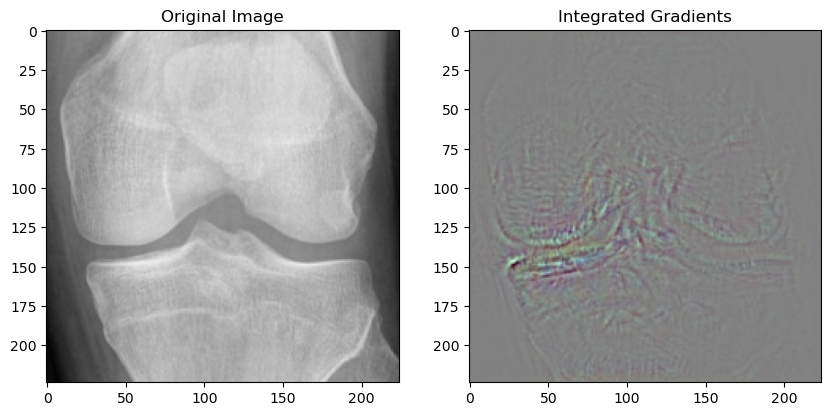

In [46]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Custom F1 Score metric
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


# Load the trained model
combined_model = load_model('final_model-60.h5', custom_objects={'f1_score': f1_score})


# Load and preprocess an image
img_path = '/Users/senu2k/Documents/UniDocs/3rdYear/fyp_projects/dataset/input_com/test/0/9006407L.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Compute integrated gradients
ig = integrated_gradients(img_array, combined_model)

# Visualize the integrated gradients
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_array[0])
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Integrated Gradients')
normalized_ig = (ig - np.min(ig)) / (np.max(ig) - np.min(ig))
plt.imshow(normalized_ig[0], cmap='viridis')
# plt.axis('off')

plt.show()


In [47]:
preds = combined_model.predict(img_array)
print("Model predictions:", preds)
print("Integrated Gradients:", ig)


2023-10-19 00:09:40.658082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Model predictions: [[6.1417001e-01 3.1220034e-01 7.0202745e-02 3.2863992e-03 1.4059535e-04]]
Integrated Gradients: tf.Tensor(
[[[[-6.75207775e-05 -8.44177630e-05 -1.06171006e-04]
   [-2.64581649e-05 -1.55729012e-05 -7.85334705e-05]
   [-3.81376844e-06  2.45138708e-05 -4.47287857e-05]
   ...
   [-2.66432799e-05 -5.56511914e-05 -4.01206817e-05]
   [-1.27341500e-05 -3.31694464e-05 -2.24766645e-05]
   [-5.95425490e-07 -9.04995250e-06 -4.75904653e-06]]

  [[-5.21609836e-05 -5.66720446e-05 -1.14053946e-04]
   [ 7.76573434e-05  1.30102213e-04 -8.20828336e-06]
   [ 1.45063605e-04  2.35002779e-04  8.07071920e-05]
   ...
   [-5.51250523e-05 -8.97732898e-05 -6.84749612e-05]
   [-2.86165596e-05 -5.39485009e-05 -3.86470638e-05]
   [-8.57832958e-07 -1.03084312e-05 -4.52677614e-06]]

  [[ 2.42244387e-05  3.87278051e-05 -4.60962037e-05]
   [ 1.46519771e-04  2.02991534e-04  2.92759414e-05]
   [ 1.53030676e-04  2.37088141e-04  4.46817685e-05]
   ...
   [

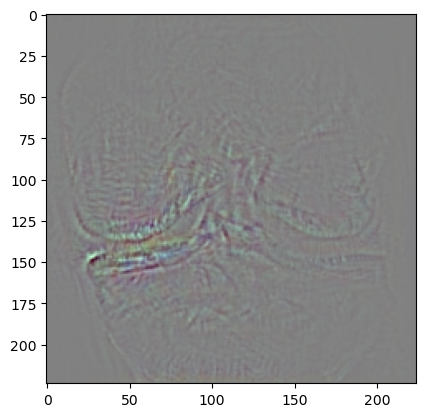

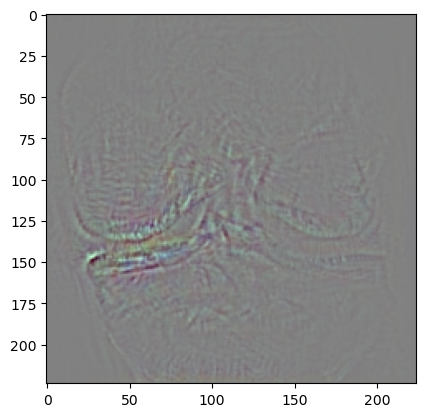

In [48]:
normalized_ig = (ig - np.min(ig)) / (np.max(ig) - np.min(ig))
plt.imshow(normalized_ig[0])
plt.show()


plt.imshow(normalized_ig[0], cmap='viridis')
plt.show()


# plt.imshow(normalized_ig[0, :, :, 0], cmap='Reds')
# plt.title('Red channel')
# plt.show()

# plt.imshow(normalized_ig[0, :, :, 1], cmap='Greens')
# plt.title('Green channel')
# plt.show()

# plt.imshow(normalized_ig[0, :, :, 2], cmap='Blues')
# plt.title('Blue channel')
# plt.show()


In [49]:
print("Min IG:", np.min(ig))
print("Max IG:", np.max(ig))


Min IG: -0.03332619
Max IG: 0.032387745
